# One-sample feedforwardness testing: simulation

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspologic.plot import heatmap
from graspologic.simulations import sample_edges, sbm
from graspologic.utils import remove_loops
from pkg.flow import rank_graph_match_flow
from pkg.io import savefig
from pkg.plot import set_theme

set_warnings()

np.random.seed(8888)

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "feedforwardness_sims"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set1")
set_theme()

## A test for feedforwardness
We'll use the simple model above to motivate a one-sided test for feedforwardness as
follows:

$$
H_0: p_{upper} = p_{lower} = p
$$

$$
H_A: p_{upper} > p_{lower}
$$

### A test statistic for feedforwardness
We aim to perform a 1-sample test for $H_0$ vs $H_a$. The test statistic we use is
simply $\hat{p}_{upper}$, the proportion of edges in the upper
triangle. To estimate this test statistic from a network, we use graph matching to
try to maximize the proportion of edges in the upper triangle (see [this notebook for
an application of this idea to team ranking](https://docs.neurodata.io/notebooks/pedigo/graspologic/graph-match/2021/03/05/ranking-via-gm.html)).

### TODO: some visual explanation of our test statistic

## Evaluating the test for different models of feedforwardness

### The upset model
This model is one of the simplest feedforward models we can think of. This model is
parameterized by two probabilities and a ranking/permutation of a set of nodes.

Let the feedforward probability be $p_{fwd}$, and let the feedback probability be
$p_{back}$. Assume we have a permutation of the nodes described by the vector of
integers $\phi \in \mathbb{R}^n$, where $n$ is the number of nodes. Each element of
$\phi$ is the node's "rank" in the network, which, along with the probabilities above,
determine its probability of connecting to other nodes in the network. Thus, each
element of $\phi$ is a unique integer $\in \{ 0 ... n - 1\}$.

If we sort $P$ according to $\phi$ (largest to smallest) then $P$ looks as follows:

$$
P_{ij} = \begin{cases}
p_{fwd} & i < j \\
p_{back} & i > j \\
0 & i = j \\
\end{cases}
$$

Thus, $P$ has all $p_{fwd}$ on the upper triangle, and all $p_{back}$ on the lower
triangle. Note that this can equivalently be parameterized as

$$
p = \frac{p_{fwd} + p_{back}}{2} \quad
\delta = \frac{p_{fwd} - p_{back}}{2}
$$

Under this parameterization, $\delta \in [0, 0.5]$ can be thought of as how
feedforward the network is - high values mean feedforward edges are far much more
likely, and thus the network structure respects the ranking $\phi$ more. $p$ then just
sets the overall density of the network.

<AxesSubplot:title={'center':'A (estimated permutation)\n$p_{upper} = $0.65'}>

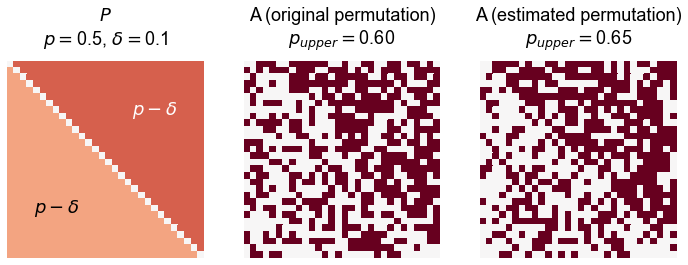

In [2]:


def calculate_p_upper(A):
    A = remove_loops(A)
    n = len(A)
    triu_inds = np.triu_indices(n, k=1)
    upper_triu_sum = A[triu_inds].sum()
    total_sum = A.sum()
    upper_triu_p = upper_triu_sum / total_sum
    return upper_triu_p


def construct_feedforward_P(n, p=0.5, delta=0):
    triu_inds = np.triu_indices(n, k=1)
    p_upper = p + delta
    p_lower = p - delta
    P = np.zeros((n, n))
    P[triu_inds] = p_upper
    P[triu_inds[::-1]] = p_lower
    return P


n = 30
p = 0.5
delta = 0.1

P = construct_feedforward_P(n, p=p, delta=delta)

A = sample_edges(P, directed=True, loops=False)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# TODO make a plot of Phat
title = r"$P$" + "\n"
title += r"$p = $" + f"{p}, " + r"$\delta = $" + f"{delta}"
ax = axs[0]
heatmap(P, vmin=0, vmax=1, cbar=False, ax=ax, title=title)
ax.text(n / 4, 3 * n / 4, r"$p - \delta$", ha="center", va="center")
ax.text(3 * n / 4, n / 4, r"$p - \delta$", ha="center", va="center", color="white")

p_upper = calculate_p_upper(A)
title = "A (original permutation)\n"
title += r"$p_{upper} = $" + f"{p_upper:0.2f}"
heatmap(A, cbar=False, ax=axs[1], title=title)

perm_inds = rank_graph_match_flow(A)
p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])

title = "A (estimated permutation)\n"
title += r"$p_{upper} = $" + f"{p_upper:0.2f}"
heatmap(A[np.ix_(perm_inds, perm_inds)], cbar=False, ax=axs[2], title=title)

#### Simulate from the null
Here, we set

$$
p = 0.5\\
n = 30\\
\delta = 0
$$

After sampling each network we compute the test statistic above, and collect these
test statistics for our null distribution.

In [3]:


def sample_null_distribution(sample_func, tstat_func, n_samples=1000, print_time=True):
    null = []
    currtime = time.time()
    for i in range(n_samples):
        A = sample_func()
        tstat = tstat_func(A)
        null.append(tstat)
    if print_time:
        print(f"{time.time() - currtime:.3f} seconds elapsed.")
    null = np.array(null)
    null = np.sort(null)
    return null


def sample_upset():
    P = construct_feedforward_P(n, p=p, delta=0)
    A = sample_edges(P, directed=True, loops=False)
    return A


def p_upper_tstat(A):
    perm_inds = rank_graph_match_flow(A)
    p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])
    return p_upper


null = sample_null_distribution(sample_upset, p_upper_tstat)

30.464 seconds elapsed.


#### Simulate from the alternative and test for feedforwardness
Here, we let the "amount of feedforwardness", $\delta$, vary from 0 to 0.25. $\delta$
can be interpreted as the effect size. For each $\delta$ we sample 200 graphs, and run
a test for feedforwardness. The test computes the test statistic described above, and
then compares to the bootstrapped null distribution we computed above to calculate a
p-value.

Note that here I am calculating p-values using the same null distribution for all of
these tests (for now, just for simplicity).
This assumes that the parameter $p$ is known, thus we only need to estimate $\delta$.
In real data we would have to use the plug in estimate of $\hat{p}$ which is the ER
global connection probability that we'd estimate from the data
(i.e. $\frac{M}{N (N - 1)}$), and then we'd sample networks from that model to
generate our bootstrap null distribution.

Also note that there are plenty of other reasonable null models we could use to
generate our null distribution, including degree-corrected ER.

In [4]:


def compute_statistics(A, null):
    row = {}
    row["sampled_p_upper"] = calculate_p_upper(A)
    p_upper = p_upper_tstat(A)
    row["estimated_p_upper"] = p_upper
    row["estimated_p"] = np.sum(A) / (A.size - len(A))
    ind = np.searchsorted(null, p_upper)
    row["pvalue"] = 1 - ind / len(
        null
    )  # TODO make more exact but this is roughly right
    return row


deltas = np.linspace(0, 0.25, num=11)
n_samples = 200
rows = []
currtime = time.time()
for delta in deltas:
    P = construct_feedforward_P(n, p=p, delta=delta)
    for i in range(n_samples):
        row = {}
        # sample
        A = sample_edges(P, directed=True, loops=False)
        row = compute_statistics(A, null)
        row["delta"] = delta
        row["str_delta"] = f"{delta:0.3f}"
        rows.append(row)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

results = pd.DataFrame(rows)

65.485 seconds elapsed.


#### Create a color map

In [5]:
str_deltas = np.unique(results["str_delta"])
colors = sns.color_palette("husl", len(str_deltas))
palette = dict(zip(str_deltas, colors))
for i, d in enumerate(str_deltas):
    palette[float(d)] = colors[i]

#### Plot the p-values from varying effect sizes

<AxesSubplot:xlabel='Effect size ($\\delta$)', ylabel='p-value'>

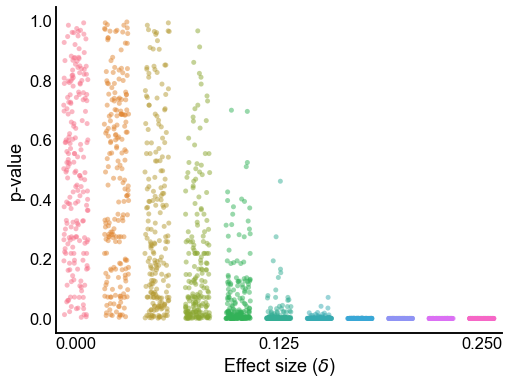

In [6]:
def plot_pvalues(results):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.stripplot(
        data=results,
        x="str_delta",
        y="pvalue",
        hue="str_delta",
        palette=palette,
        zorder=2,
        alpha=0.5,
        jitter=0.3,
    )
    ax.get_legend().remove()
    ax.set(xlabel=r"Effect size ($\delta$)", ylabel="p-value")
    ax.xaxis.set_major_locator(plt.FixedLocator([0, 5, 10]))
    return ax


plot_pvalues(results)

#### Plot the distribution p-values under the null

<AxesSubplot:title={'center':'ECDF under $H_0$'}, xlabel='p-value', ylabel='Cumulative density'>

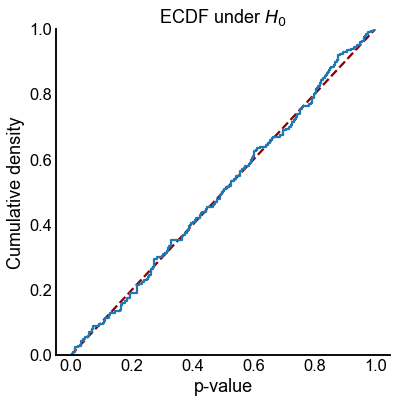

In [7]:


def plot_null_ecdf(results):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.ecdfplot(data=results[results["str_delta"] == "0.000"], x="pvalue")
    ax.set(xlabel="p-value", ylabel="Cumulative density", title=r"ECDF under $H_0$")
    ax.plot([0, 1], [0, 1], color="darkred", linestyle="--", zorder=-1)
    return ax


plot_null_ecdf(results)

#### Plot power for $\alpha = 0.05$

<AxesSubplot:xlabel='Effect size ($\\delta$)', ylabel='Power'>

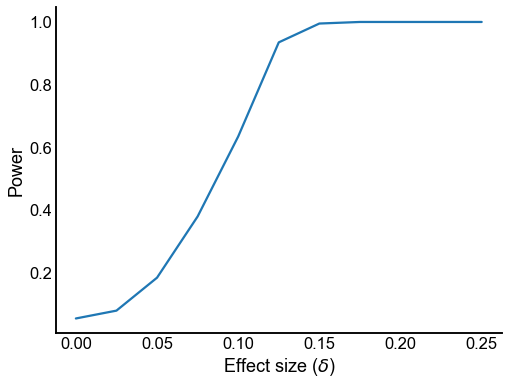

In [8]:
def calc_power_at(x, alpha=0.05):
    return (x < alpha).sum() / len(x)


def plot_power(results):
    grouped_results = results.groupby("str_delta")
    power = grouped_results["pvalue"].agg(calc_power_at)
    power.name = "power"
    power = power.to_frame().reset_index()
    power["delta"] = power["str_delta"].astype(float)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.lineplot(data=power, x="delta", y="power", ax=ax)
    ax.set(ylabel="Power", xlabel=r"Effect size ($\delta$)")
    return ax


plot_power(results)

#### Plot the "true" and estimated upper triangle probabilities
By true upper triangle probabilies, we mean the proportion of edges in the upper
triangle under the permutation that we sampled the graph from, $\phi$. The estimated
upper triangle probability is what we estimate after permuting the network using
graph matching.

Note that it may be possible to permute a network from its starting permutation $\phi$
to make even more edges in the upper triangle. Conversely, it's possible that graph
matching fails to find a permutation with as many upper triangular edges as the
original permutation (which we of course wouldn't know on real data).

[Text(0.5, 0, '$p_{upper}$ under original permutation'),
 Text(0, 0.5, '$p_{upper}$ under estimated permutation')]

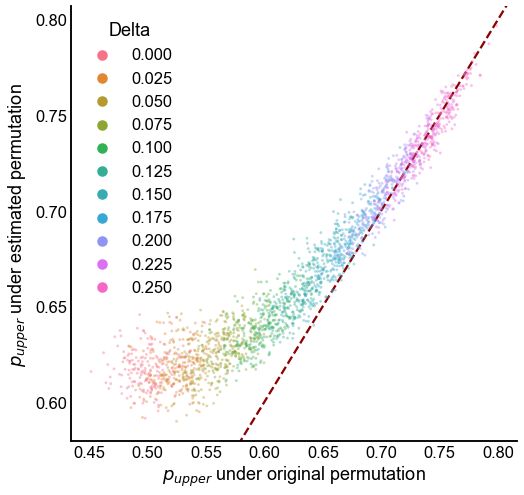

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=results,
    x="sampled_p_upper",
    y="estimated_p_upper",
    hue="str_delta",
    s=8,
    alpha=0.4,
    linewidth=0,
    ax=ax,
    zorder=10,
    palette=palette,
)
ax.get_legend().set_title("Delta")
plt.autoscale(False)
ax.plot([0, 1], [0, 1], color="darkred", linestyle="--", zorder=-1)
ax.set(
    xlabel=r"$p_{upper}$ under original permutation",
    ylabel=r"$p_{upper}$ under estimated permutation",
)

### A feedforward SBM model
Here we construct a 2-block SBM where the block probabilities are feedforward with an
amount that depends on $\delta$.

<AxesSubplot:title={'center':'A (estimated permutation)\n$p_{upper} = $0.65'}>

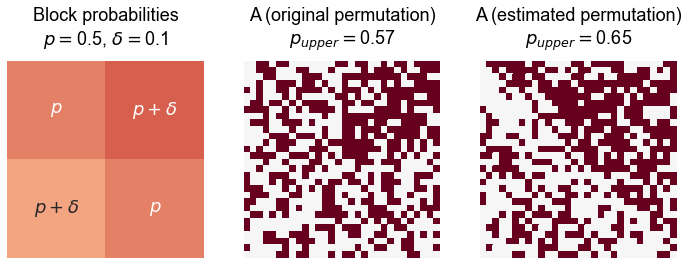

In [10]:


def construct_feedforward_B(p=0.5, delta=0):
    B = np.array([[p, p + delta], [p - delta, p]])
    return B


delta = 0.1
B = construct_feedforward_B(0.5, delta)
ns = [15, 15]
A, labels = sbm(ns, B, directed=True, loops=False, return_labels=True)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

title = "Block probabilities\n"
title += r"$p = $" + f"{p}, " + r"$\delta = $" + f"{delta}"
annot = np.array([[r"$p$", r"$p + \delta$"], [r"$p + \delta$", r"$p$"]])
sns.heatmap(
    B,
    vmin=0,
    center=0,
    vmax=1,
    cmap="RdBu_r",
    annot=annot,
    cbar=False,
    square=True,
    fmt="",
    ax=axs[0],
    xticklabels=False,
    yticklabels=False,
)
axs[0].set_title(title, pad=16.5)

p_upper = calculate_p_upper(A)
title = "A (original permutation)\n"
title += r"$p_{upper} = $" + f"{p_upper:0.2f}"
heatmap(A, cbar=False, ax=axs[1], title=title)

perm_inds = rank_graph_match_flow(A)
p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])

title = "A (estimated permutation)\n"
title += r"$p_{upper} = $" + f"{p_upper:0.2f}"
heatmap(A[np.ix_(perm_inds, perm_inds)], cbar=False, ax=axs[2], title=title)

#### Simulate from the null

In [11]:

B = construct_feedforward_B(0.5, 0)


def sample_func():
    return sbm(ns, B, directed=True, loops=False)


null = sample_null_distribution(sample_func, p_upper_tstat)

29.691 seconds elapsed.


#### Simulate from the alternative and test for feedforwardness

In [12]:

deltas = np.linspace(0, 0.25, num=11)
n_samples = 200
rows = []
currtime = time.time()
for delta in deltas:
    B = construct_feedforward_B(p, delta)
    for i in range(n_samples):
        row = {}
        # sample
        A = sbm(ns, B, directed=True, loops=False)
        row = compute_statistics(A, null)
        row["delta"] = delta
        row["str_delta"] = f"{delta:0.3f}"
        rows.append(row)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

results = pd.DataFrame(rows)

64.146 seconds elapsed.


#### Plot the p-values from varying effect sizes

<AxesSubplot:xlabel='Effect size ($\\delta$)', ylabel='p-value'>

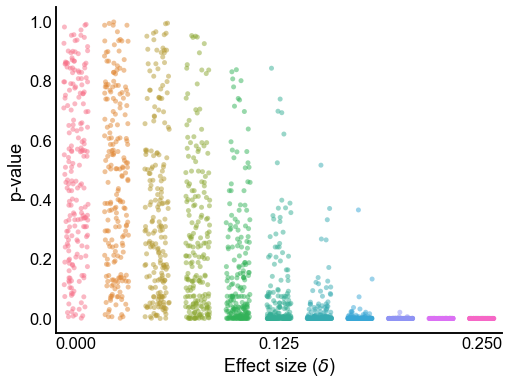

In [13]:
plot_pvalues(results)

#### Plot the distribution p-values under the null

<AxesSubplot:title={'center':'ECDF under $H_0$'}, xlabel='p-value', ylabel='Cumulative density'>

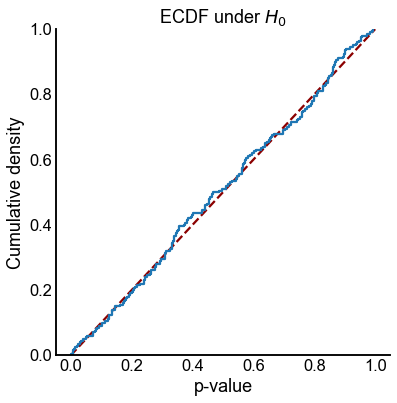

In [14]:
plot_null_ecdf(results)

#### Plot power for $\alpha = 0.05$

<AxesSubplot:xlabel='Effect size ($\\delta$)', ylabel='Power'>

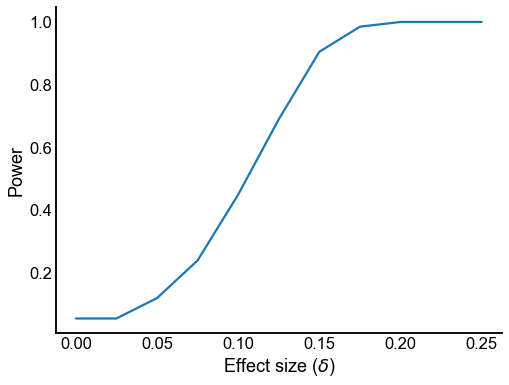

In [15]:
plot_power(results)

## End

In [16]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:03:14.758523
Completed at 2021-03-24 14:25:22.496200
----
